# Neural Network with numpy on cancer detection 

Firstly, this Kernel is only for educational purpose. Here we will not focus on getting the best accuracy and instead we will focus on how to build our own feedforward neural network, which is far more inferior than Convolutional Networks (atleast for this task). We are going to build this network on numpy and not use any framework which is, again, not optimal because using a framework will be much faster to code and run. But building all the parts of the feedforward neural network will teach you a lot more about the structure and the algorithms that the network uses. 

At the end we will try to optimize the network with mini-batches and ADAM.

Sources: 
https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.coursera.org/learn/neural-networks-deep-learning/home/welcome

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import cv2,os
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import math
import sklearn.datasets
import gc

First we want to load our data.

In [2]:
# glob module finds all the pathnames matching "../input/train/*.tif", so every training image
# {} creates dictionary
df = pd.DataFrame({'path': glob(os.path.join("../input/train/",'*.tif'))})

# names are /input/train/namefile.tif but we only want the namefile
# lambda function is a small anonymous function
# map() function applies the lambda function to each item of our df.path
# make sure that the name "id" stays the same because we want it to be identical to the name of the coloumn of label
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) 

labels = pd.read_csv("../input/train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths


The first step is always to analyze the data before building the network.

0    130908
1     89117
Name: label, dtype: int64

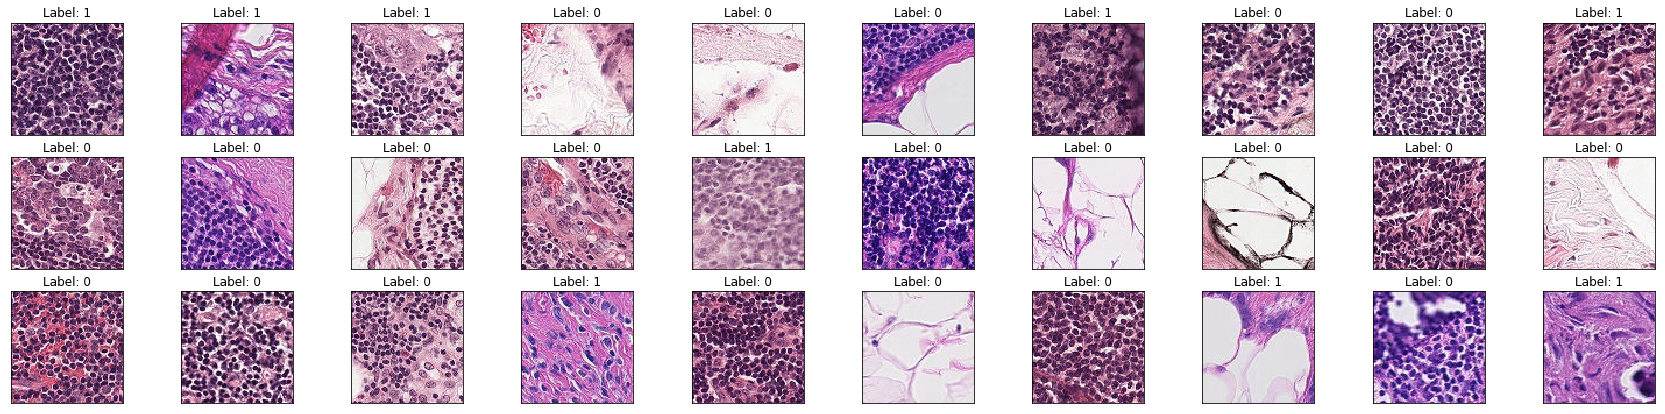

In [3]:
df.head(3) # print the first three entrys

fig = plt.figure(figsize=(30, 7))

# We want to plot some of the pictures with the right label
# enumerate gives us (loop index, id of training images) whereas we start with loop index = 1
for image_number, img_id in enumerate(np.random.choice(df["id"], 30), 1):
    # gives us subplots with 2 rows and 20//2 = 10 pictures and image_number to plot in this index
    ax = fig.add_subplot(3, 30 // 3, image_number, xticks=[], yticks=[])
    # show the current image
    im = Image.open("../input/train/" + img_id + ".tif")
    plt.imshow(im)
    # Find the training label with the same id as our training image via id, values[0] gives us the right format (was a pd.Series)
    lab = labels.loc[labels['id'] == img_id, 'label'].values[0]
    # x = 6   f"label: {x}" gives us "label: 6"
    ax.set_title(f'Label: {lab}')

labels["label"].value_counts()


For the untrained eye it is very hard to distinguish between a cancer cell and a healthy cell. Let's hope that our network will do better! We can also see that our data is slighty inbalanced: 59,5% negatives, 40.5 positives.

## Structure

Now we will build our own feedforward network. We are not going to build the whole model in one function instead we will build "helper" functions. They essentially are little building blocks of the network. Here is an overview:

**1) initialization_he **     -  Initialization of the weights und shift vectors (bias)

**2) forward propagation** (divided into 2 functions)

1.   one_step_forward  - One step of the forward propagation   
2.   NN_forward        - Forward Propagation
   
**3) compute_cost **          - Compute the cost

**4) Backward propagation **  (divided into 4 functions)

1.   relu_deriv        - computing the derivative of the ReLU function  
2.   sigmoid_deriv     - computing the derivative of the sigmoid function  
3.   one_step_backprop - One step of the backward propagation   
4.   NN_backward       - Backward Propagation
   
**5) update_parameters **     - update the weights und shift vector according to the gradient descent of backprop

At the end we will build our model with these help functions. After that we will try to optimize our network with mini-batch and ADAM.

## 1) First step:  Initialization of the weights und the shift vector (bias)



In [4]:
# First step:  Initialization of the weights und the shift vector (bias)
def initialization(layer_dims):
# Input: array containing dimension of each layer, ex. (3,4,1) has 3 Inputs, 4 hidden units in the first layer and 1 output
# for our NN layer_dims = (96*96*3, 5, 5, 5, 5, 1)
# Returns: parameters <-> python dictionary containing "W1","b1",...,"WL","bL" the weights and the shift vector
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

We set the weight matrices randomly, but there is a more faster and more efficient way to initialize the weights.

The He Initialization:
The initialization of the weights are now depending on the previous layer. The weights are still random but differ in range depending on the size of the previous layer.
We will use this method for our model


In [5]:

def initialization_he(layers_dims):
# Input: array containing dimension of each layer, ex. (3,4,1) has 3 Inputs, 4 hidden units in the first layer and 1 output
# for our NN layer_dims = (96*96*3, ...)
# Returns: parameters <-> python dictionary containing "W1","b1",...,"WL","bL" the weights and the shift vector
    parameters = {}
    L = len(layers_dims) - 1  # integer representing the number of layers

    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

##  2) Second Step: Forward Propagation 
* 2.1) First we build a function for one forward step

In [6]:
# Second Step: Forward Propagation
# First we build a function for one forward step

def one_step_forward(A_prev, W,b, activation):
# Input: A_prev  <-> output of activation from previous layer.  W,b <-> Weights, shift vector from current layer
# activation <-> activation function "relu" or "sigmoid"
# Return: A <-> output of activation.  cache <-> python dictionary containing A,W,b,Z

    if activation == "sigmoid":
        Z = np.dot(W,A_prev) + b
        A = 1/(1+np.exp(-Z))
    elif activation == "relu":
        Z = np.dot(W,A_prev) + b
        A = np.maximum(0,Z)
    cache = ((A_prev,W,b),Z)

    return A, cache

2.2) Secondly we build the forward propagation for the whole Neural Network.

In [7]:
def NN_forward (X, parameters):
# Inputs: X <-> data, numpy array of shape (input size, number of examples)
# parameters <-> output of initialization()
# Returns: AL -- last post-activation value
# caches <-> list of caches containing: every cache of one_step_forward

    caches = []
    # m training examples
    L = len(parameters)//2
    A = X
    for l in range(1,L):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A , cache = one_step_forward (A_prev,W,b,"relu")
        caches.append(cache)
    AL, cache = one_step_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

##  3) Cost function
* Now we will implement the Cost function before we go on with the backpropagate (obv we need the cost function for the backprop.)
* Because we have a binary classification problem we are going to use the Log Loss function 


In [8]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1 / m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1 - Y), np.log(1 - AL)))
    cost = np.squeeze(cost)  # e.g. this turns [[1]] into 1
    assert (cost.shape == ())
    return cost

## 4) Now we will build our backpropagation:
* 4.1) relu_deriv        - computing the derivative of the ReLU function  
* 4.2) sigmoid_deriv     - computing the derivative of the sigmoid function 

In [9]:
def relu_deriv(Z):
    Z[Z<=0] =0 
    Z[Z>0] = 1 
    return Z

def sigmoid_deriv(Z):
    s = 1 / (1 + np.exp(-Z))
    deriv = s*(1-s)
    return deriv

4.3) one_step_backprop - First we will implement one step of backprop just like in forward prop

In [10]:
def one_step_backprop(dA, cache, activation):
    (A_prev,W,b) , Z = cache
    m = A_prev.shape[1]

    if activation == "relu":
        dZ = np.multiply(dA, relu_deriv(Z))
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
    elif activation == "sigmoid":
        dZ = np.multiply(dA, sigmoid_deriv(Z))
        dW = 1/m* np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis = 1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
    assert (dZ.shape == Z.shape)
    return dA_prev, dW, db

4.4) NN-backward - Now we will implement backprop for the whole Neural Network


In [11]:
def NN_backward(AL, Y, caches):
    """
    Inputs: AL <-> probability vector, output of the forward propagation (L_model_forward())
    Y <-> true "label" vector (containing 0 if non-cat, 1 if cat)
    caches <-> list of caches containing:
                every cache with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # same shape as AL
    
    # Start with the last layer:
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = one_step_backprop(dAL,current_cache,"sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = one_step_backprop(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

## 5) update_parameters - - update the weights und shift vector according to the gradient descent of backprop

In [12]:
# The next step is to update our parameters
def update_parameters(parameters, grads , learning_rate):
    L = len(parameters) //2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

Finally, we can use those functions to build our Neural Network!

In [13]:
def model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): 
    costs = []  # keep track of cost

    parameters = initialization_he(layers_dims)
    N = num_iterations

    for i in tqdm_notebook(range(num_iterations), total=N):
        if i == N:
            break

        # Forward propagation: 
        AL, caches = NN_forward(X, parameters)

        # Compute cost.
        cost = compute_cost(AL, Y)

        # Backward propagation.
        grads = NN_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost) 


    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

We are done! Now lets see how our Neural Network does. First we need the data in the right form, that means in an array, where the features are in the rows and the examples in the coloumns. Our features consists of 96 times 96 pixels and 3 compomentens (red, green, blue) for each pixel. That means we have 96 times 96 times 3 = 27648 features! 


In [14]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    # read images one by one, tdqm notebook displays a progress bar
    # df.iterrows() iterates over DataFrame rows as (index, Series) pairs
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
    y = y.reshape((1,N))

    return X,y

Before we run our data through our model, we a training and test set. The following function splits our data into those 2 sets, 

In [15]:
def split_data(X,y, percentage):
    split_ex = round(X.shape[1] * percentage)  # gives us the numbers of examples for the training
    X_train = X[:, :split_ex]
    X_test = X[:, split_ex:]
    y_train = y[:, :split_ex]
    y_test = y[:, split_ex:]
    return X_train, y_train, X_test, y_test

Loading our data.

In [16]:
layers_dims = [96*96*3, 60, 30, 15 , 5, 1]
m = 19000
X, y = load_data(m,df)
# shape as (-1, 96*96*3). row unknown, column 96*96*3
X = X.reshape(-1,96*96*3).T
print(X.shape)
X_train, y_train, X_test, y_test = split_data (X,y, 0.9)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(27648, 19000)
(27648, 17100)
(1, 17100)
(27648, 1900)
(1, 1900)


In [17]:
df = None
gc.collect()

11

We are going to project our data into the intervall [0,1]. It is going to be easier to train our model with these values.

In [18]:
X_train = X_train / 255
X_test = X_test / 255


The following function is used to predict the results of our neural network.

In [19]:
def predict(X, y, parameters):
    """.
    Input: X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = NN_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print(np.sum(p))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

Now we can train and predict the labels for the training set and we will see how our network does.

Cost after iteration 0: 0.716319
Cost after iteration 100: 0.668700
Cost after iteration 200: 0.667542
Cost after iteration 300: 0.666450
Cost after iteration 400: 0.665095
Cost after iteration 500: 0.663275
Cost after iteration 600: 0.660717
Cost after iteration 700: 0.655716
Cost after iteration 800: 0.645776
Cost after iteration 900: 0.627247
Cost after iteration 1000: 0.622871
Cost after iteration 1100: 0.620285
Cost after iteration 1200: 0.618046
Cost after iteration 1300: 0.616748
Cost after iteration 1400: 0.614080
Cost after iteration 1500: 0.611752
Cost after iteration 1600: 0.609499
Cost after iteration 1700: 0.606929
Cost after iteration 1800: 0.604418
Cost after iteration 1900: 0.602309
Cost after iteration 2000: 0.599742
Cost after iteration 2100: 0.597215
Cost after iteration 2200: 0.594849
Cost after iteration 2300: 0.592347
Cost after iteration 2400: 0.593233
Cost after iteration 2500: 0.590674
Cost after iteration 2600: 0.586098
Cost after iteration 2700: 0.577751
Cost

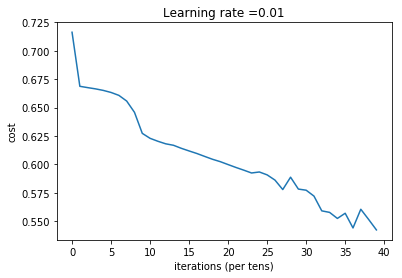

predictions: [[1. 0. 0. ... 1. 0. 0.]]
true labels: [[1 0 0 ... 1 0 0]]
7221.0
Accuracy: 0.7644444444444447
predictions: [[1. 0. 0. ... 1. 0. 0.]]
true labels: [[1 1 0 ... 1 1 0]]
837.0
Accuracy: 0.6884210526315788


In [20]:
learning_rate = 0.01
parameters =  model(X_train, y_train, layers_dims, learning_rate, num_iterations= 4000, print_cost = True)
pred_train = predict(X_train, y_train, parameters)
pred_test = predict(X_test, y_test, parameters)

OPTIONAL: We could try to optimize our network with mini-batches and the so called algorithm ADAM.

First we will implement the mini-batches.

In [21]:
'''
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Inputs: X <-> input data, of shape (input size, number of examples)
    Y <-> true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size <-> size of the mini-batches, integer
    
    Returns:
    mini_batches <-> list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X_shuffled[ :, (mini_batch_size*k):(mini_batch_size*(k+1)) ]
        mini_batch_Y = Y_shuffled[ :, (mini_batch_size*k):(mini_batch_size*(k+1))]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X_shuffled[ :, (mini_batch_size*num_complete_minibatches):]
        mini_batch_Y = Y_shuffled[ :, (mini_batch_size*num_complete_minibatches):]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
'''

'\ndef random_mini_batches(X, Y, mini_batch_size = 64):\n    """\n    Inputs: X <-> input data, of shape (input size, number of examples)\n    Y <-> true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)\n    mini_batch_size <-> size of the mini-batches, integer\n    \n    Returns:\n    mini_batches <-> list of synchronous (mini_batch_X, mini_batch_Y)\n    """\n    \n    m = X.shape[1]                  # number of training examples\n    mini_batches = []\n    # Step 1: Shuffle (X, Y)\n    permutation = list(np.random.permutation(m))\n    X_shuffled = X[:, permutation]\n    Y_shuffled = Y[:, permutation].reshape((1,m))\n\n    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.\n    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning\n    for k in range(0, num_complete_minibatches):\n        mini_batch_X = X_shuffled[ :, (mini_batch_size*k):(mini_batch_size*(k+1)) ]\n

## Model with mini batch

In [22]:
''' 
    
    def model_minibatch(X, Y, layers_dims, learning_rate=0.0075, mini_batch_size =512, num_iterations=3000, print_cost=False): 
    costs = []  # keep track of cost

    parameters = initialization_he(layers_dims)
    N = num_iterations
    
    for i in tqdm_notebook(range(num_iterations), total=N):
        if i == N:
            break
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        
        for minibatch in minibatches:
            
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation: 
            AL, caches = NN_forward(minibatch_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, minibatch_Y)

            # Backward propagation.
            grads = NN_backward(AL, minibatch_Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)
            

         # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
'''

' \n    \n    def model_minibatch(X, Y, layers_dims, learning_rate=0.0075, mini_batch_size =512, num_iterations=3000, print_cost=False): \n    costs = []  # keep track of cost\n\n    parameters = initialization_he(layers_dims)\n    N = num_iterations\n    \n    for i in tqdm_notebook(range(num_iterations), total=N):\n        if i == N:\n            break\n        minibatches = random_mini_batches(X, Y, mini_batch_size)\n        \n        for minibatch in minibatches:\n            \n            # Select a minibatch\n            (minibatch_X, minibatch_Y) = minibatch\n            \n            # Forward propagation: \n            AL, caches = NN_forward(minibatch_X, parameters)\n\n            # Compute cost.\n            cost = compute_cost(AL, minibatch_Y)\n\n            # Backward propagation.\n            grads = NN_backward(AL, minibatch_Y, caches)\n\n            # Update parameters.\n            parameters = update_parameters(parameters, grads, learning_rate)\n            \n\n      

We could also try to optimize our model with the algorithm ADAM.

In [23]:
'''
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    ### END CODE HERE ###
    
    return v, s
'''

'\ndef initialize_adam(parameters) :\n    """\n    Initializes v and s as two python dictionaries with:\n                - keys: "dW1", "db1", ..., "dWL", "dbL" \n                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.\n    \n    Arguments:\n    parameters -- python dictionary containing your parameters.\n                    parameters["W" + str(l)] = Wl\n                    parameters["b" + str(l)] = bl\n    \n    Returns: \n    v -- python dictionary that will contain the exponentially weighted average of the gradient.\n                    v["dW" + str(l)] = ...\n                    v["db" + str(l)] = ...\n    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.\n                    s["dW" + str(l)] = ...\n                    s["db" + str(l)] = ...\n\n    """\n    \n    L = len(parameters) // 2 # number of layers in the neural networks\n    v = {}\n    s = {}\n    \n    # Initialize v

In [24]:
'''
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-6):
    
    Input 
    parameters <-> python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads  <-> python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v  <-> Adam variable, moving average of the first gradient, python dictionary
    s  <-> Adam variable, moving average of the squared gradient, python dictionary
    learning_rate <-> the learning rate, scalar.
    beta1  <-> Exponential decay hyperparameter for the first moment estimates 
    beta2  <-> Exponential decay hyperparameter for the second moment estimates 
    epsilon  <-> hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters  <-> python dictionary containing your updated parameters 
    v  <-> Adam variable, moving average of the first gradient, python dictionary
    s  <-> Adam variable, moving average of the squared gradient, python dictionary
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".

        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW"+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db"+str(l+1)]


        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**t)
#

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*grads["dW"+str(l+1)]**2
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*grads["db"+str(l+1)]**2


        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] /(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] /(1-beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate* v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate* v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)


    return parameters, v, s
'''

'\ndef update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,\n                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-6):\n    \n    Input \n    parameters <-> python dictionary containing your parameters:\n                    parameters[\'W\' + str(l)] = Wl\n                    parameters[\'b\' + str(l)] = bl\n    grads  <-> python dictionary containing your gradients for each parameters:\n                    grads[\'dW\' + str(l)] = dWl\n                    grads[\'db\' + str(l)] = dbl\n    v  <-> Adam variable, moving average of the first gradient, python dictionary\n    s  <-> Adam variable, moving average of the squared gradient, python dictionary\n    learning_rate <-> the learning rate, scalar.\n    beta1  <-> Exponential decay hyperparameter for the first moment estimates \n    beta2  <-> Exponential decay hyperparameter for the second moment estimates \n    epsilon  <-> hyperparameter preventing division by zero in Adam updates\n\n    

## Model with ADAM

In [25]:
''' 

def model_adam(X, Y, layers_dims, learning_rate=0.0075, mini_batch_size = 256, beta = 0.9, beta1 = 0.9, beta2 = 0.999,epsilon = 1e-8, 
          num_epochs = 1500, print_cost=True):  
    costs = []  # keep track of cost

    parameters = initialization_he(layers_dims)
    N = num_epochs
    t = 0     # for Adam
    v, s = initialize_adam(parameters)
    for i in tqdm_notebook(range(num_epochs), total=N):
        if i == N:
            break
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        
        for minibatch in minibatches:
            
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation: 
            AL, caches = NN_forward(minibatch_X, parameters)

            # Compute cost.
            cost = compute_cost(AL, minibatch_Y)

            # Backward propagation.
            grads = NN_backward(AL, minibatch_Y, caches)

            # Update parameters.
            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
            

         # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
            costs.append(cost)


    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters
'''

' \n\ndef model_adam(X, Y, layers_dims, learning_rate=0.0075, mini_batch_size = 256, beta = 0.9, beta1 = 0.9, beta2 = 0.999,epsilon = 1e-8, \n          num_epochs = 1500, print_cost=True):  \n    costs = []  # keep track of cost\n\n    parameters = initialization_he(layers_dims)\n    N = num_epochs\n    t = 0     # for Adam\n    v, s = initialize_adam(parameters)\n    for i in tqdm_notebook(range(num_epochs), total=N):\n        if i == N:\n            break\n        minibatches = random_mini_batches(X, Y, mini_batch_size)\n        \n        for minibatch in minibatches:\n            \n            # Select a minibatch\n            (minibatch_X, minibatch_Y) = minibatch\n            \n            # Forward propagation: \n            AL, caches = NN_forward(minibatch_X, parameters)\n\n            # Compute cost.\n            cost = compute_cost(AL, minibatch_Y)\n\n            # Backward propagation.\n            grads = NN_backward(AL, minibatch_Y, caches)\n\n            # Update paramete